[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mycarta/fastbook_sandbox/blob/main/02a_production_jmd_image_scraper_train_and_inference.ipynb)


### Preliminaries

In [40]:
! [ -e /content ] && pip install -Uqq fastai

     |████████████████████████████████| 720 kB 7.3 MB/s 
     |████████████████████████████████| 46 kB 5.6 MB/s 
     |████████████████████████████████| 1.2 MB 51.8 MB/s 
     |████████████████████████████████| 51 kB 403 kB/s 


The above cell is to upgrade fastai on colab (from here: https://github.com/fastai/fastai/blob/master/nbs/10_tutorial.pets.ipynb)

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [47]:
from fastai.vision.all import *
from fastai.vision.widgets import *

### Using an lternative to BING for Downloading images

Setting up Bing image search is getting even worse than it was at the time the book was written. It is possible with [the the updated Microsoft Azure Bing Search V7 [as documented in this post](https://towardsdatascience.com/classifying-images-of-alcoholic-beverages-with-fast-ai-34c4560b5543). 

A good alternative to Bing is Joe Dockrill's `jmd_imagescraper`:
- docs in [here](https://joedockrill.github.io/jmd_imagescraper/)
-  blog post in [here](https://joedockrill.github.io/blog/2020/09/18/jmd-imagescraper-library/)

There is a TowardsDatacience [post](https://forums.fast.ai/t/duck-duck-go-code-not-working/85287/7?u=mycarta)  essentially doing what I am doing here, more or less.

One thing to test at a later date in the __shape__ is the size of images allowed, e.g. square vs. rectangular (see [comments](https://github.com/joedockrill/blog/issues/3#issuecomment-709595914) ).

In [4]:
!pip install -q jmd_imagescraper 
# quiet installation (no "Requirements already satisfied"warnings)

In [5]:
from jmd_imagescraper.core import duckduckgo_search 

In [6]:
bear_types = 'grizzly bear','black bear','teddy bear'

In [7]:
from pathlib import Path
path = Path().cwd()/"Bears"
for o in bear_types:
  duckduckgo_search(path, o, o, max_results=80)

Duckduckgo search: grizzly bear


Duckduckgo search: black bear


Duckduckgo search: teddy bear


### Check and remove some images. 
For example at the time of the search (September 21st 2021) there's a few examples in the black bear folder that are in fact grizzly bears. 

In [8]:
fns = get_image_files(path)
len(fns)

240

In [9]:
from jmd_imagescraper.imagecleaner import *
display_image_cleaner(path)

HTML(value='<h2>No images left to display in this folder.</h2>', layout=Layout(visibility='hidden'))

GridBox(children=(VBox(children=(Image(value=b'', layout="Layout(width='150px')"), Button(description='Delete'…

In [10]:
fns = get_image_files(path)
len(fns)

222

In [11]:
failed = verify_images(fns)
failed

(#0) []

In [12]:
failed.map(Path.unlink);

### From Data to DataLoaders

In [13]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [14]:
dls = bears.dataloaders(path)

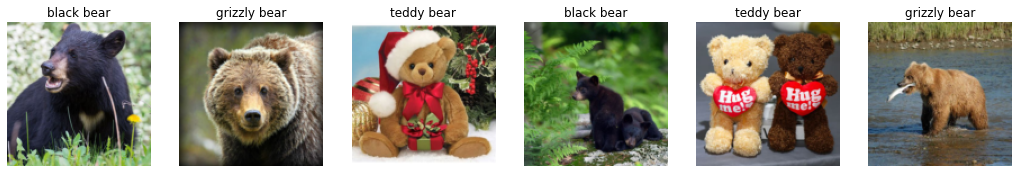

In [15]:
dls.valid.show_batch(max_n=6, nrows=1)

### Data Augmentation example

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


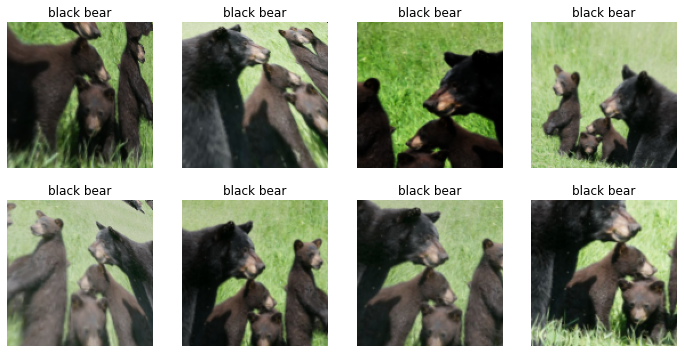

In [16]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3), 
                  batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

### Train a model

In [17]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5), 
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [18]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


SuggestedLRs(valley=0.0008317637839354575)

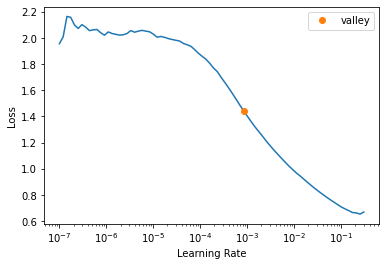

In [19]:
learn.lr_find()

In [20]:
learn.fine_tune(4, 0.0008)

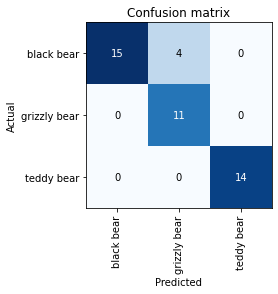

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

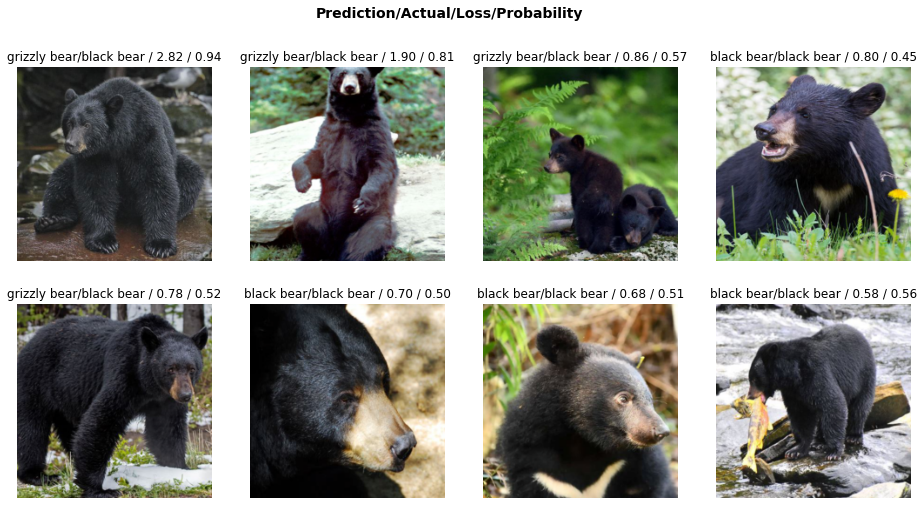

In [23]:
interp.plot_top_losses(8, nrows=2, figsize=(16,8))

### Delete and relocate some more images again after training (model-driven data cleaning) then re-train

Definitely a couple of images in the top losses. Plus a few more.

In [24]:
fns = get_image_files(path)
len(fns)

222

In [25]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [27]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [28]:
fns = get_image_files(path)
len(fns)

219

### Re-train the model

In [29]:
dls = bears.dataloaders(path)
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

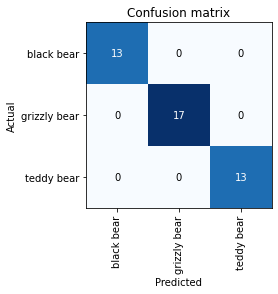

In [30]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Use the model for inference (on a single new image)

Check these:

In [ ]:
#doc(learn.save) 

In [ ]:
#doc(learn.load)

In [ ]:
#doc(learn.export)

In [ ]:
#doc(load_learner)

In [31]:
learn.export()

In [32]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [33]:
learn_inf = load_learner(path/'export.pkl')

In [34]:
learn_inf.dls.vocab

['black bear', 'grizzly bear', 'teddy bear']

In [53]:

url = 'https://upload.wikimedia.org/wikipedia/commons/a/a9/GrizzlyBearJeanBeaufort.jpg'
dest = 'images/grizzly_test.jpg'

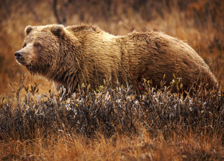

In [56]:
img = download_url(url, dest)
im = Image.open(dest)
im.to_thumb(224,224)

In [60]:
learn_inf.predict(dest)

('grizzly bear', tensor(1), tensor([3.7755e-07, 1.0000e+00, 1.7851e-07]))

In [61]:
learn_inf.dls.vocab[1]

'grizzly bear'